# Hate Speech Detector 2.0
---
**Extended hateful and vulgar phrase dictionaries analysis; Duplicated data analysis**
1. Duplicated data analysis:
    1. Reperforming of the whole data quantitative and qualitive analysis after certain rows duplication.
    2. Single class cardinalities (%) + comparison with unduplicated data results.
    3. Combination of classes cardinalities (UpSet plot).
2. Extended data analysis:
    1. Reperforming of phrases quantitative and qualitive analysis for extended dictionaries.
    2. Hateful phrases cardinalities (with stacked bar of additional phrases)

In [1]:
import numpy as np
import pandas as pd

import re

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
from upsetplot import UpSet

import os
import csv
import pickle

In [2]:
LABELS = ['wyzywanie', 'grożenie', 'wykluczanie', 'odczłowieczanie', 'poniżanie', 'stygmatyzacja', 'szantaż']
LABELS_SMALL = ['wyz', 'groz', 'wyk', 'odcz', 'pon', 'styg', 'szan']
LABELS_V_SMALL = LABELS_SMALL + ['vulg']

COMBINED_PATH = 'data/tweets_sady/main/sady_combined.csv'
DUPLICATED_PATH = 'data/tweets_sady/processed/sady_duplicated.csv'

HATEFUL_LEMM_DIR = 'data/hateful/lemm_{}.txt'
HATEFUL_EXT_DIR = 'data/hateful/ext_{}.txt'

In [3]:
pd.set_option('display.max_colwidth', 400)

In [4]:
plt.style.use('ggplot')

**Polish stopwords**

In [5]:
with open('data/other/polish_stopwords.txt', 'r') as f:
    polish_stopwords = f.read().split('\n')[:-1]
polish_stopwords[:10]

['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ']

## Class cardinalities

In [6]:
df_combined = pd.read_csv(COMBINED_PATH)
df_duplicated = pd.read_csv(DUPLICATED_PATH)

### Single classes

**Unduplicated**

In [7]:
def classes(df, convert_null=False):
    df_c = df[LABELS]
    if convert_null:
        df_c = df_c.notnull().astype('int')
    
    return df_c

df_classes_c = classes(df_combined, convert_null=True)
df_classes_c.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0


In [8]:
def class_single_cards(df_c):
    df = df_c[df_c.columns]
    
    df['total'] = np.ones(len(df_c), dtype=np.int32)
    srs_c = df.sum().sort_values(ascending=False)
    srs_perc = pd.Series(srs_c/len(df)*100).sort_values(ascending=False)
    
    df_sc = pd.DataFrame({
        'label': srs_c.index,
        'cardinality': srs_c.values,
        '%': srs_perc.values
    })
    df_sc = df_sc.set_index('label')
    
    return df_sc

df_single_cards_c = class_single_cards(df_classes_c)
df_single_cards_c

,cardinality,%
label,,
total,15202,100.000000
stygmatyzacja,830,5.459808
poniżanie,700,4.604657
grożenie,393,2.585186
wyzywanie,242,1.591896
odczłowieczanie,174,1.144586
wykluczanie,94,0.618340
szantaż,6,0.039468


**Duplicated**

In [9]:
df_classes_d = classes(df_duplicated)
df_classes_d

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
15786,0,0,0,0,0,0,0
15787,0,0,0,0,0,0,0
15788,0,0,0,0,0,0,0
15789,0,0,0,0,0,0,0


In [10]:
df_single_cards_d = class_single_cards(df_classes_d)
df_single_cards_d

,cardinality,%
label,,
total,15791,100.000000
stygmatyzacja,1096,6.940662
poniżanie,1040,6.586030
grożenie,717,4.540561
wyzywanie,532,3.369008
wykluczanie,452,2.862390
odczłowieczanie,419,2.653410
szantaż,60,0.379963


**Comparison**

In [11]:
def class_single_cards_comp(df_sc_c, df_sc_d):
    df_comp = pd.DataFrame({
        'hate type': df_sc_c.index,
        'card. before': df_sc_c['cardinality'].values,
        '% before': df_sc_c['%'].values,
        'card. after': df_sc_d['cardinality'].values,
        '% after': df_sc_d['%'].values,
    })
    df_comp = df_comp.set_index('hate type')
    
    return df_comp

df_single_class_comp = class_single_cards_comp(df_single_cards_c, df_single_cards_d)
df_single_class_comp

,card. before,% before,card. after,% after
hate type,,,,
total,15202,100.000000,15791,100.000000
stygmatyzacja,830,5.459808,1096,6.940662
poniżanie,700,4.604657,1040,6.586030
grożenie,393,2.585186,717,4.540561
wyzywanie,242,1.591896,532,3.369008
odczłowieczanie,174,1.144586,452,2.862390
wykluczanie,94,0.618340,419,2.653410
szantaż,6,0.039468,60,0.379963


**Visualizations**

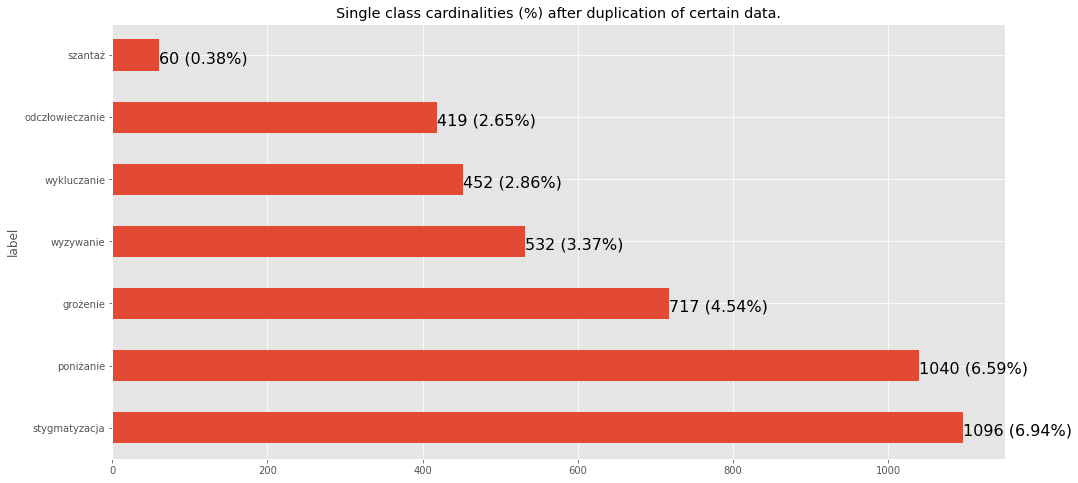

In [12]:
def single_cardinalities_bar(df_sc, title='Single class cardinalities (%) after duplication of certain data.'):
    ax = df_sc['cardinality'][1:].plot(kind='barh', figsize=(16, 8))
    for p, perc in zip(ax.patches, df_sc['%'][1:]):
        plt.text(p.get_width(), p.get_y()+0.25*p.get_height(), f'{p.get_width()} ({perc:1.2f}%)', fontsize=16)

    plt.title(title)
    plt.show()

single_cardinalities_bar(df_single_cards_d)

The 'stygmatyzacja' (6.94%) and 'poniżanie' (6.59%) labels are at the top. The 'odczłowieczanie' (2.65%) and 'szantaż' (0.38%) are at the bottom.

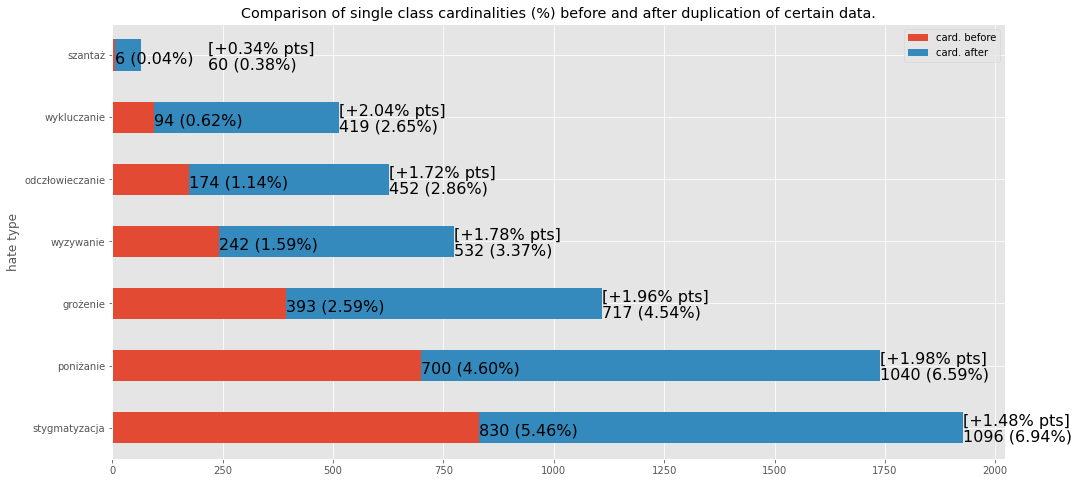

In [13]:
def single_cardinalities_comp_bar(df_sc_comp, title='Comparison of single class cardinalities (%) before and after duplication of certain data.'):
    ax = df_sc_comp[1:][['card. before', 'card. after']].plot(kind='barh', stacked=True, figsize=(16, 8))
    for p, (cb, pb, ca, pa) in zip(ax.patches, df_sc_comp[1:].values):
        text0 = f'{int(cb)} ({pb:1.2f}%)'
        plt.text(cb, p.get_y()+0.25*p.get_height(), text0, fontsize=16)
        text1a = f'{int(ca)} ({pa:1.2f}%)'
        text1b = f'[{"+" if pa>pb else ""}{pa-pb:1.2f}% pts]'
        plt.text(ca+cb + (150 if ca-cb<100 else 0), p.get_y()+0.05*p.get_height(), text1a, fontsize=16)
        plt.text(ca+cb + (150 if ca-cb<100 else 0), p.get_y()+0.55*p.get_height(), text1b, fontsize=16)

    plt.title(title)
    plt.show()

single_cardinalities_comp_bar(df_single_class_comp)

The 'wykluczanie' recorded the highest increase [+2.04% pts] and the 'szantaż' - the lowest [+0.34% pts].

### Combinations of classes

In [14]:
df_single_cards_d

,cardinality,%
label,,
total,15791,100.000000
stygmatyzacja,1096,6.940662
poniżanie,1040,6.586030
grożenie,717,4.540561
wyzywanie,532,3.369008
wykluczanie,452,2.862390
odczłowieczanie,419,2.653410
szantaż,60,0.379963


In [15]:
def class_combination_cards(df_c):
    df = df_c[df_c.columns]
    
    df['cardinality'] = np.ones(len(df_c), dtype=np.int32)
    df_cc = df.groupby(LABELS).count().sort_values(by='cardinality', ascending=False)
    df_cc['%'] = df_cc['cardinality']/len(df_c)*100
    
    return df_cc

df_combination_cards = class_combination_cards(df_classes_d)
df_combination_cards

cardinality  \
wyzywanie grożenie wykluczanie odczłowieczanie poniżanie stygmatyzacja szantaż                
0         0        0           0               0         0             0              13654   
                                                         1             0                361   
                                               1         0             0                251   
                                                         1             0                197   
          1        0           0               0         0             0                179   
                                                         1             0                106   
1         0        0           0               1         0             0                 57   
                                               0         0             0                 43   
                               1               1         1             0                 40   
0         0        0           1               0         0             0                 36   
1         0        0           0               1         1             0                 32   
0         1        1           0               0         0             0                 32   
          0        0           1               1         0             0                 23   
1         0        1           0               1         1             0                 20   
                   0           1               0         1             0                 20   
                                               1         0             0                 20   
                   1           0               0         0             0                 20   
                                               1         0             0                 20   
                   0           1               0         0             0                 20   
                   1           1               1         1             0                 20   
                                                         0             0                 20   
          1        0           0               0         0             0                 20   
                                                         1             0                 20   
                                               1         0             0                 20   
                                                         1             0                 20   
                   1           0               0         0             0                 20   
                                               1         0             0                 20   
                                                                       1                 20   
                                                         1             0                 20   
          0        0           0               0         1             0                 20   
0         1        1           0               0         1             0                 20   
                               1               0         0             0                 20   
          0        1           1               1         1             0                 20   
                   0           1               0         1             0                 20   
                                               1         1             0                 20   
                   1           0               0         0             0                 20   
                                                         1             0                 20   
                                               1         0             0                 20   
                                                         1             0                 20   
                               1               0         0             0                 20   
                                               1         0             0                 2

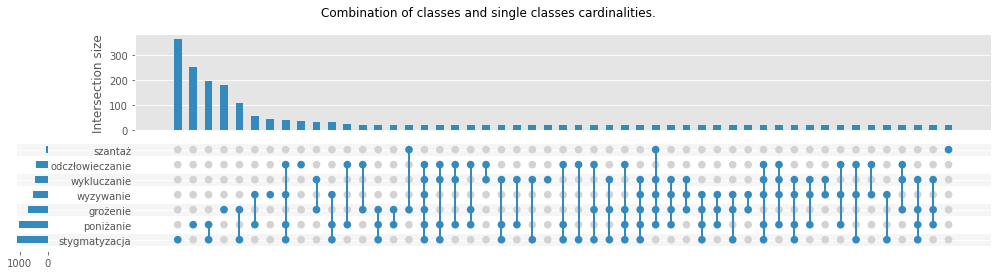

In [16]:
def combination_cardinalities_upset(df_cc, title='Combination of classes and single classes cardinalities.', color='red'):
    upset = UpSet(df_cc['cardinality'][1:], sort_by='cardinality', facecolor=color, element_size=22)
    upset.plot()

    plt.suptitle(title)
    plt.show()

combination_cardinalities_upset(df_combination_cards, color='#348abd')

Now all existing class combinations cardinalities are not less than 20.

## Lemmatized and extended phrase dictionaries

**Lemmatized phrases**

In [17]:
def load_lemm_phrases(load_vulg=False):
    aphr = list([])
    for label in LABELS_SMALL:
        with open(HATEFUL_LEMM_DIR.replace('{}', label), 'r') as f:
            aphr.append(np.array(f.read().split(';')))
    if load_vulg:
        with open(VULGARS_LEMM_DIR.replace('{}', LABELS_V_SMALL[-1]), 'r') as f:
            aphr.append(np.array(f.read().split(';')))
    
    return np.array(aphr)

lemm_phrases = load_lemm_phrases()

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


**Extended phrases**

In [18]:
def load_ext_phrases(load_vulg=False):
    aphr = list([])
    for label in LABELS_SMALL:
        with open(HATEFUL_EXT_DIR.replace('{}', label), 'r') as f:
            aphr.append(np.array(f.read().split(';')))
    if load_vulg:
        with open(VULGARS_EXT_DIR.replace('{}', LABELS_V_SMALL[-1]), 'r') as f:
            aphr.append(np.array(f.read().split(';')))
    
    return np.array(aphr)

ext_phrases = load_ext_phrases()

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


**Visualizations**

In [19]:
def phrase_cards(aphr):
    df_pc = pd.DataFrame({
        'hate type': LABELS,
        'cardinality': [len(phr) for phr in aphr]
    })
    df_pc = df_pc.set_index(['hate type'])
    
    return df_pc

df_phrase_cards = phrase_cards(ext_phrases)
df_phrase_cards

,cardinality
hate type,
wyzywanie,383
grożenie,722
wykluczanie,201
odczłowieczanie,255
poniżanie,1158
stygmatyzacja,1100
szantaż,21


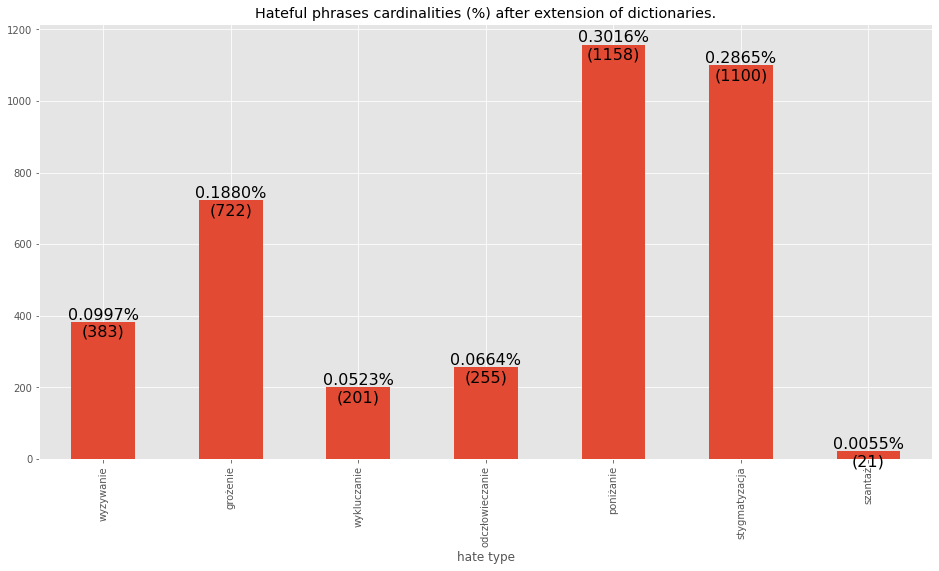

In [20]:
def phrase_cardinalities_bar(df_pc, title='Hateful phrases cardinalities (%) after extension of dictionaries.'):
    ax = df_pc.plot(kind='bar', figsize=(16, 8))
    ax.get_legend().remove()
    for p in ax.patches:
        perc = p.get_height()/df_pc['cardinality'].sum()
        plt.text(p.get_x() + p.get_width()/2, p.get_height()-50, f'{perc:1.4f}%\n({p.get_height()})',
                 ha='center', va='bottom', fontsize=16)

    plt.title(title)
    plt.show()

phrase_cardinalities_bar(df_phrase_cards)

In [21]:
def phrase_cards_comp(lemm_aphr, ext_aphr):
    df_pcc = pd.DataFrame({
        'hate type': LABELS,
        'cardinality': [len(phr) for phr in lemm_aphr],
        #'ext. count': [len(phr) for phr in ext_aphr]
        'ext. cardinality': [380, 400, 250, 200, 750, 900, 50]
    })
    df_pcc = df_pcc.set_index(['hate type'])
    
    return df_pcc

df_phrase_cards_comp = phrase_cards_comp(lemm_phrases, ext_phrases)

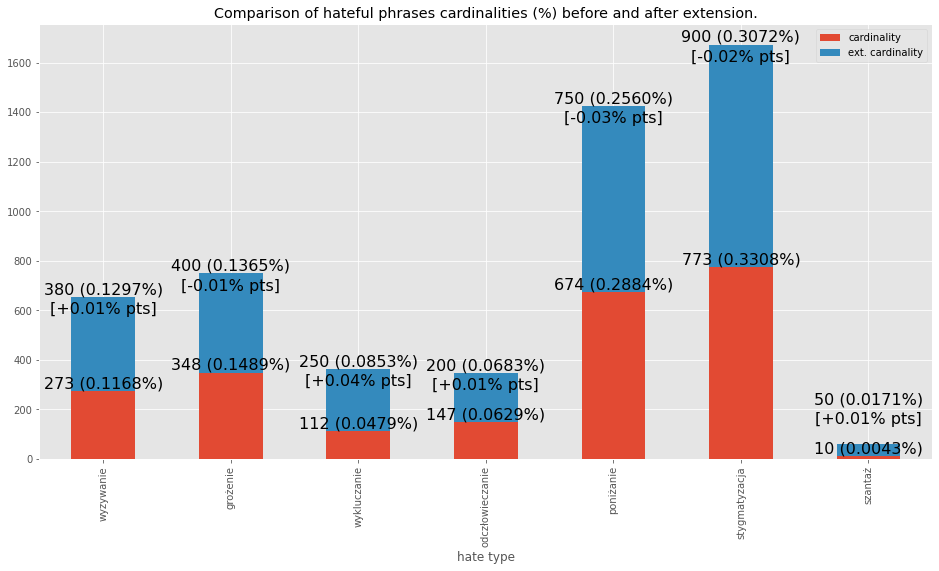

In [22]:
def phrase_cardinalities_bar_comp(df_pcc, title='Comparison of hateful phrases cardinalities (%) before and after extension.'):
    ax = df_pcc.plot(kind='bar', stacked=True, figsize=(16, 8))
    for p, (cb, ca) in zip(ax.patches, df_pcc.values):
        pb = cb/df_pcc['cardinality'].sum()
        pa = ca/df_pcc['ext. cardinality'].sum()
        text0 = f'{int(cb)} ({pb:1.4f}%)'
        plt.text(p.get_x() + p.get_width()/2, cb, text0, ha='center', va='bottom', fontsize=16)
        text1a = f'{int(ca)} ({pa:1.4f}%)'
        text1b = f'[{"+" if pa>pb else ""}{pa-pb:1.2f}% pts]'
        plt.text(p.get_x() + p.get_width()/2, ca+cb + (150 if ca-cb<50 else 0), text1a, ha='center', va='bottom', fontsize=16)
        plt.text(p.get_x() + p.get_width()/2, ca+cb + (150 if ca-cb<50 else 0)-80, text1b, ha='center', va='bottom', fontsize=16)

    plt.title(title)
    plt.show()

phrase_cardinalities_bar_comp(df_phrase_cards_comp)

The 'wykluczanie' recorded the highest increase [+0.04% pts] and the 'poniżanie' noticed the highest decrease [-0.03% pts].